# plotting returns: comparing stocks with indices

Related: [Plotting a stock's price chart with corporate action overlay](https://github.com/stockviz/plutons/blob/master/charting-stocks-with-corporate-actions.R.ipynb)

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(RPostgres)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
equitiesIndiaNse <- EquitiesIndiaNse()
indices <- Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Registering fonts with R

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package

In [2]:
symbol <- "YESBANK"
indexName <- "NIFTY BANK TR"
startDt <- as.Date(Sys.Date() - 10*365) #10-year chart
endDt <- Sys.Date()

# examples: https://github.com/shyams80/plutons/blob/master/docs-R/EquitiesIndiaNse.ipynb

#make sure that the data exists

equitiesIndiaNse$EodTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt 
           & SYMBOL == symbol 
           & (SERIES == 'EQ' | SERIES == 'BE')) %>%
    summarize(MAX_DT = max(TIME_STAMP), MIN_DT = min(TIME_STAMP)) %>%
    print()

equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt 
           & SYMBOL == symbol) %>%
    summarize(MAX_DT = max(TIME_STAMP), MIN_DT = min(TIME_STAMP)) %>%
    print()


Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

# Source:   lazy query [?? x 2]
# Database: Microsoft SQL Server 13.00.4259[ro1@NORWAY/StockViz]
  MAX_DT     MIN_DT    
  <date>     <date>    
1 2019-07-19 2009-07-24
# Source:   lazy query [?? x 2]
# Database: postgres [ro1@SWEDEN:5432/StockVizDyn]
  MAX_DT     MIN_DT    
  <date>     <date>    
1 2019-07-19 2009-07-24


In [3]:
# so the data exists in both so we can use the EodAdjustedTimeSeries

eodPx <- equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt & SYMBOL == symbol) %>%
    select(TIME_STAMP, CLOSE) %>%
    arrange(TIME_STAMP) %>%
    collect() 

indexPx <- indices$NseTimeSeries() %>%
    filter(NAME == indexName && TIME_STAMP >= startDt && TIME_STAMP <= endDt) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() 

dailies <- merge(dailyReturn(xts(eodPx$CLOSE, as.Date(eodPx$TIME_STAMP))), 
                 dailyReturn(xts(indexPx$CLOSE, as.Date(indexPx$TIME_STAMP))))

names(dailies) <- c(symbol, indexName)

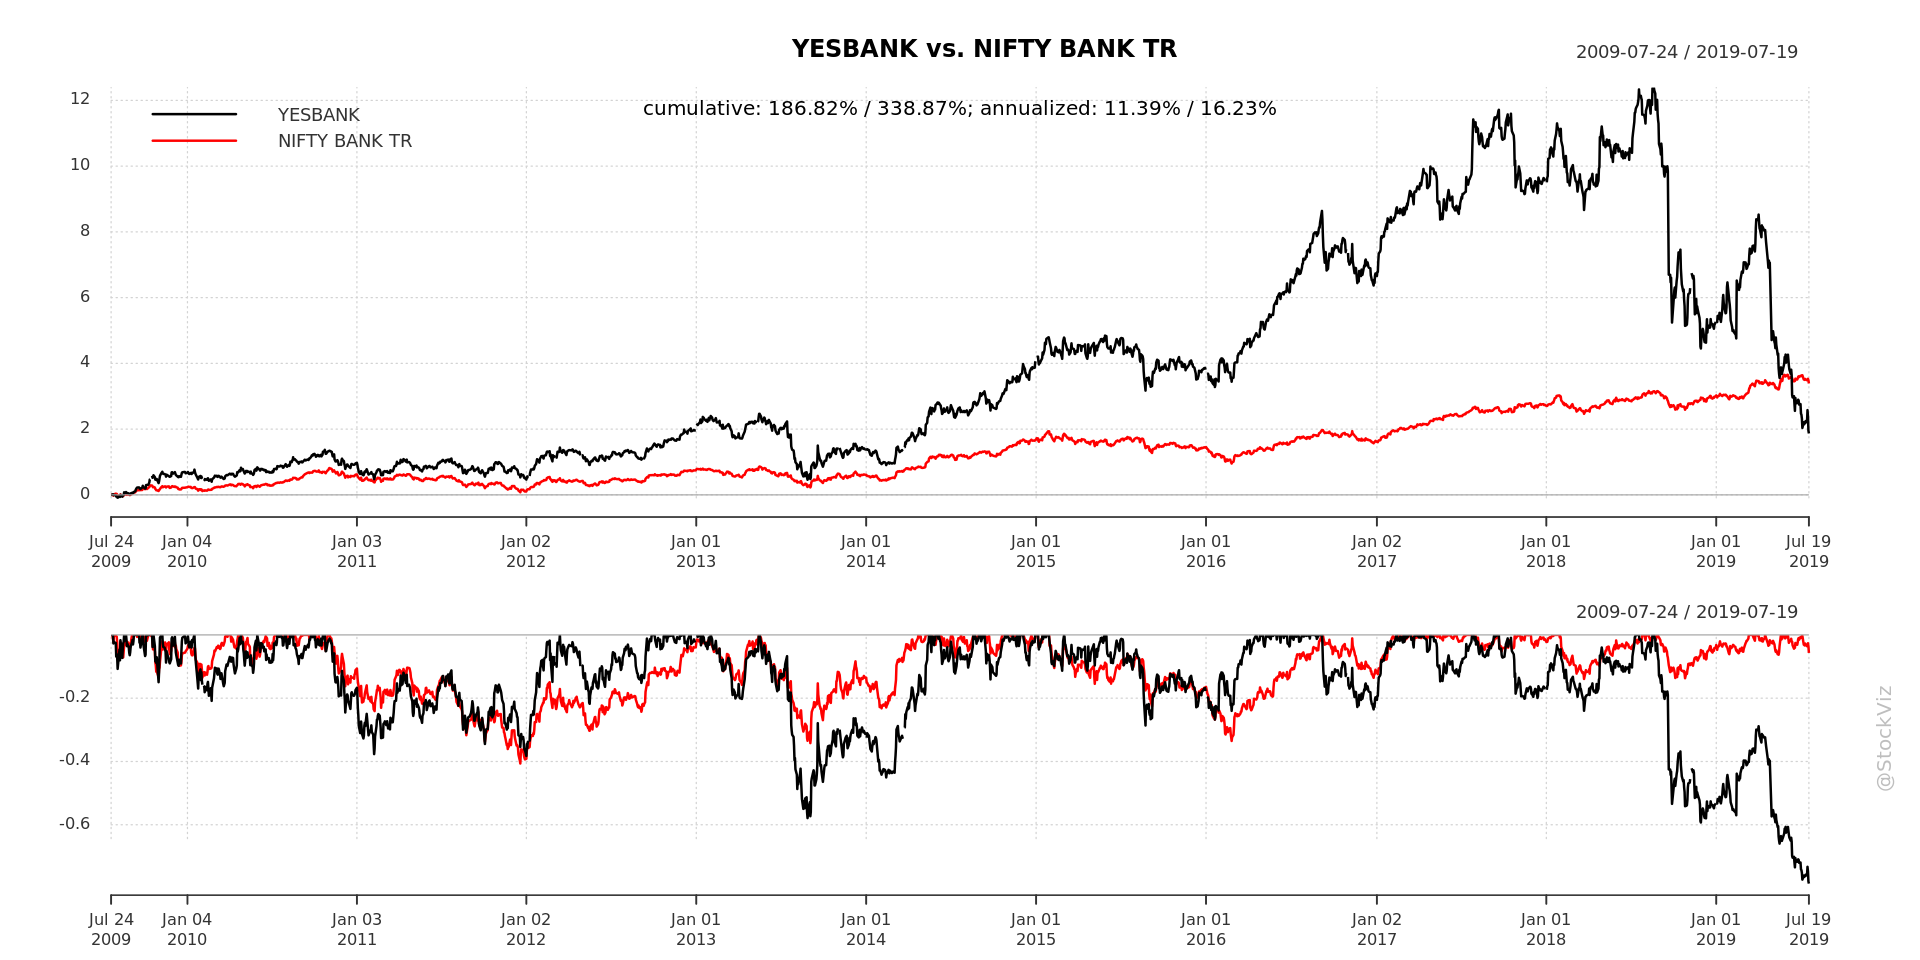

In [4]:
startDate <- first(index(dailies))
endDate <- last(index(dailies))

xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

Common.PlotCumReturns(dailies, sprintf("%s vs. %s", symbol, indexName), "")

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)